<a href="https://colab.research.google.com/github/filipemcbarros/modelos_classificadores_conciliacao/blob/main/analise_dados_estatisticas_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bibliotecas utilizadas**

In [ ]:
import pandas as pd
from google.colab import drive
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_auc_score,roc_curve,accuracy_score,matthews_corrcoef,f1_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Carregamento do dataset**

In [ ]:
dataset.to_csv("/content/drive/MyDrive/Colab Notebooks/base_processos/dataset_final.csv")
dataset

## Levantamento das estatísticas do corpus limpo

In [ ]:
dataset = dataset.dropna(subset=['corpus_limpo'])

In [ ]:
# Contando o número de palavras na coluna 'corpus_limpo'
dataset['corpus_limpo'] = dataset['corpus_limpo'].fillna('')
dataset['num_palavras_corpus'] = dataset['corpus_limpo'].str.split().apply(len)

# Limpeza das linhas com corpus que possuem menos que 30 palavras para eliminar textos de referências a anexos e sem conteúdo útil
dataset = dataset.drop(dataset[dataset['num_palavras_corpus'] < 30].index)
dataset

In [ ]:
#Média da quatidade de palavras por texto presente no corpus_limpo
dataset['num_palavras_corpus'].max()

In [ ]:
dados = dataset['num_palavras_corpus']
quartis = np.percentile(dados, [25, 50, 75])
media = np.mean(dados)
desvio_padrao = np.std(dados)

In [ ]:
quartis

array([1079., 1763., 2757.])

In [ ]:
media

2171.441353815232

In [ ]:
desvio_padrao

1761.0193709560247

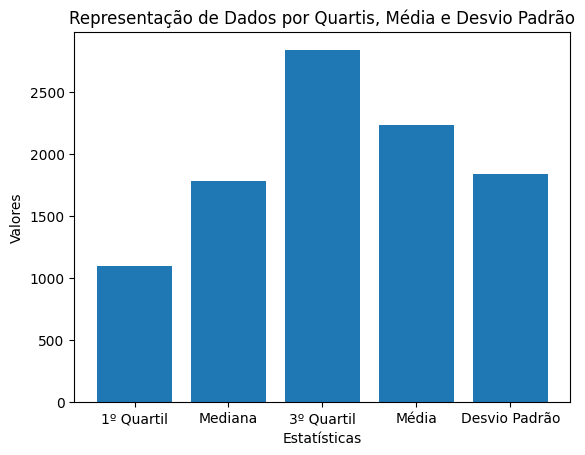

In [ ]:
etiquetas = ['1º Quartil', 'Mediana', '3º Quartil', 'Média', 'Desvio Padrão']

# Valores para plotagem
valores = np.concatenate((quartis, [media, desvio_padrao]))

# Plotagem do gráfico de barras
plt.bar(etiquetas, valores)
plt.xlabel('Estatísticas')
plt.ylabel('Valores')
plt.title('Representação de Dados por Quartis, Média e Desvio Padrão')
plt.show()

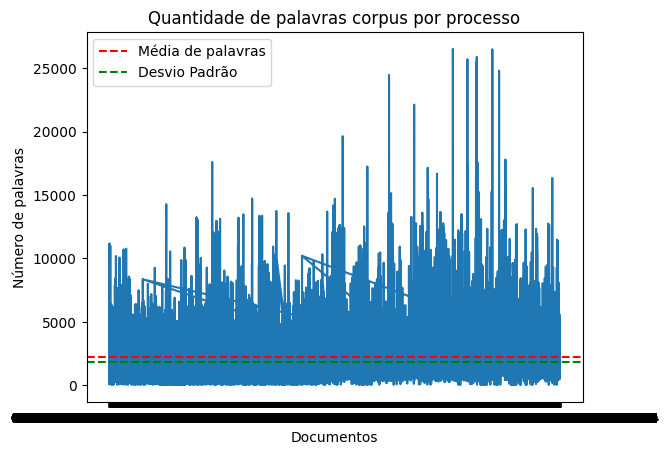

In [ ]:
# Plotando o gráfico de barras
plt.plot(dataset['num_processo'],dataset['num_palavras_corpus'])

media_palavras = dataset['num_palavras_corpus'].mean()
desvio_padrao = np.std(dataset['num_palavras_corpus'])

# Adicionando uma linha com a média
plt.axhline(media_palavras, color='red', linestyle='--', label='Média de palavras')
# Adicionando uma linha com o desvio padrão
plt.axhline(desvio_padrao, color='green', linestyle='--', label='Desvio Padrão')

# Definindo os rótulos dos eixos
plt.xlabel('Documentos')
plt.ylabel('Número de palavras')

# Definindo o título do gráfico
plt.title('Quantidade de palavras corpus por processo')

plt.legend()

# Exibindo o gráfico
plt.show()

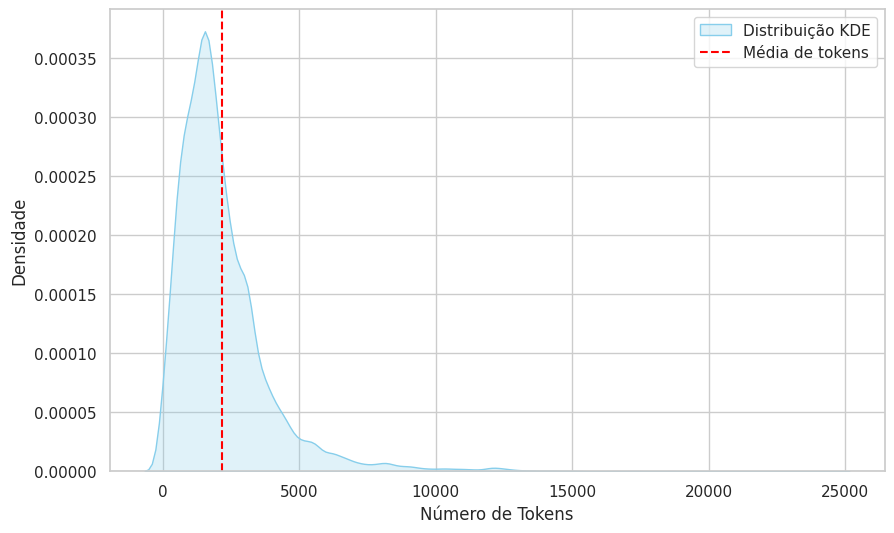

In [ ]:
# Supondo que 'dataset' é o seu DataFrame

# Configurações estéticas do Seaborn (opcional, mas melhora a aparência do gráfico)
sns.set(style="whitegrid")

# Criar o gráfico KDE de distribuição
plt.figure(figsize=(10, 6))  # Tamanho da figura

sns.kdeplot(data=dataset, x='num_palavras_corpus', fill=True, color='skyblue', label='Distribuição KDE')

# Adicionando uma linha com a média
plt.axvline(media, color='red', linestyle='--', label='Média de tokens')

# Adicionando uma linha com o desvio padrão
#plt.axvline(desvio_padrao, color='green', linestyle='--', label='Desvio Padrão')

# Definindo os rótulos dos eixos
plt.xlabel('Número de Tokens')
plt.ylabel('Densidade')

# Definindo o título do gráfico
#plt.title('Distribuição de tokens no corpus por processo')

plt.legend()

# Exibindo o gráfico
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

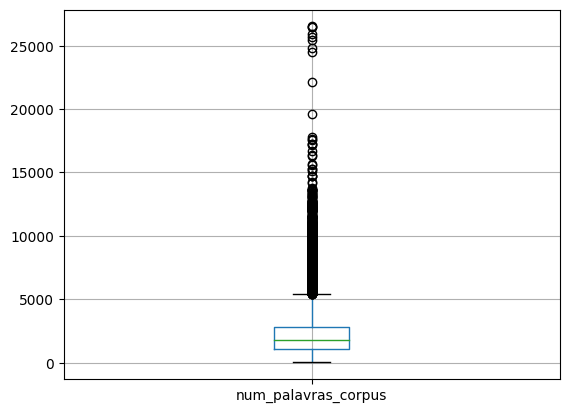

In [ ]:
dataset.boxplot(column=['num_palavras_corpus'])

In [ ]:
dataset['num_palavras_corpus'].max()

22037

# **Análise inicial dos dados contidos no dataset**

In [ ]:
print(dataset.isna().sum())

num_processo           0
corpus_limpo           0
corpus_bruto           0
conciliado             0
ano_processo           0
localidade             0
num_palavras_corpus    0
dtype: int64


Total de processos não conciliados (0):  13521 - 48.52846170411313 %
Total de processos conciliados (1):  14341 - 51.47153829588687 %


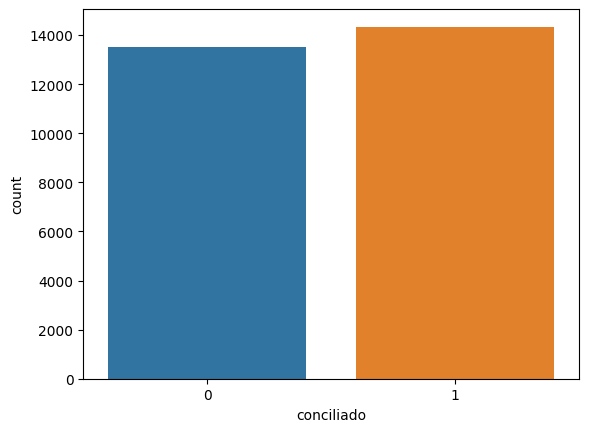

In [ ]:
#quatidades de conciliado e nao_conciliado do atributo conciliado (classe de interesse)
sns.countplot(x='conciliado', data=dataset)
conciliado,nao_conciliado = dataset['conciliado'].value_counts()
print('Total de processos não conciliados (0): ', nao_conciliado,'-', nao_conciliado/(conciliado+nao_conciliado)*100, '%')
print('Total de processos conciliados (1): ', conciliado,'-', conciliado/(conciliado+nao_conciliado)*100, '%')

# **Features e labels de interesse: peticoes e conciliado**
**corpus_peticao**: texto da petição inicial, **conciliado**: valores 1 ou 0 (conciliado ou não conciliado)

In [ ]:
features = dataset['corpus_limpo']
#features = dataset['corpus_bruto']
classes = dataset['conciliado']
processos = dataset['num_processo']

conciliados = features[(dataset['conciliado'] == 1)]
nao_conciliados = features[(dataset['conciliado'] == 0)]

# **Vetorização dos textos utilizando TF-IDF**

#**Usando as features somente dos processos conciliados**

In [ ]:
cv=CountVectorizer()

# gerar o contador de palavras para as palavras dos documentos
word_count_vector=cv.fit_transform(conciliados)
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

# valores idf
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names_out(),columns=["idf_weights"])

# ordenação crescente
df_idf.sort_values(by=['idf_weights']).head(60)

aviso	**1.371406**
previo	**1.380580**
verbas	**1.294530**
fgts	**1.286109**
ferias	**1.326756**

# **Word Cloud para os processos conciliados**

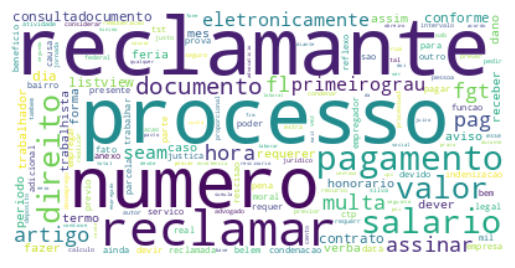

In [ ]:
text = " ".join(word for word in conciliados)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#TF-IDF
tfidf_vectorizer=TfidfVectorizer(use_idf=True)
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(conciliados)
tfidf_vectorizer_vectors.shape

(15132, 80017)

In [ ]:
# recuperar o TF-IDF de um documento
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[3]

df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names_out(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head(100)

,tfidf
dorivania,0.981041
acordo,0.153723
anexo,0.118019
2e,0.000000
obrigatorio,0.000000
...,...
obstaculizar,0.000000
obstaculizadora,0.000000
obstaculizado,0.000000
obstaculizacao,0.000000


#**Usando as features somente dos processos não conciliados**

In [ ]:
cv=CountVectorizer()

# gerar o contador de palavras para as palavras dos documentos
word_count_vector=cv.fit_transform(nao_conciliados)

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

# valores idf
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names_out(),columns=["idf_weights"])

# ordenação crescente
df_idf.sort_values(by=['idf_weights']).head(60)

,idf_weights
valor,1.031834
direito,1.033466
pagamento,1.037080
processo,1.038379
trabalhista,1.039063
reclamante,1.042285
requerer,1.046207
reclamar,1.047172
conforme,1.052014
deferimento,1.052847


verbas	**1.309957**
fgts	**1.351398**

## **Word Cloud para os processos não conciliados**

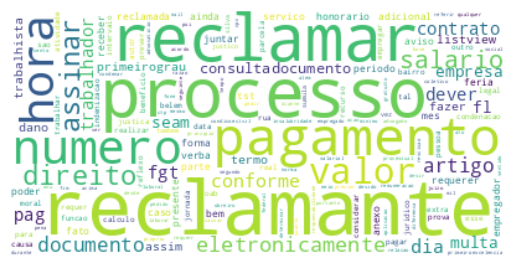

In [ ]:
text = " ".join(word for word in nao_conciliados)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#TF-IDF
tfidf_vectorizer=TfidfVectorizer(use_idf=True)
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(nao_conciliados)
tfidf_vectorizer_vectors.shape

(15191, 93950)

In [ ]:
# recuperar o TF-IDF de um documento
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[3]

df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names_out(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head(100)

,tfidf
senopetri,0.597670
petri,0.210611
seno,0.210311
hora,0.184988
parauapebas,0.178754
...,...
gastar,0.029910
acumular,0.029910
escalar,0.029653
revista,0.029650
